In [2]:
#import all modules 
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import numpy as np
import os
from numpy import asarray, save, load
import matplotlib.pyplot as plt

In [3]:
#insert the desired path containing combined data files
path = os.path.expanduser(r"~/Documents/python/identification_modified_proteins/bin_size_0.01/")

#changes current working directory to the path given 
directory = os.chdir(path)

In [5]:
#load data 
load_data = np.load('all_train_data_0.01_with_2+.npy', allow_pickle=True)
df = pd.DataFrame(load_data)

# Create feature and target arrays
X = df.drop(101300, axis=1) 
y = df[101300].astype('int') #last column is the modified or not modified feature

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4 , random_state=42, stratify=y)

# Create a k-NN classifier with 7 neighbors: knn
bayes = GaussianNB()

# Fit the classifier to the training data
bayes.fit(X_train, y_train)

# Print the accuracy
print(bayes.score(X_test, y_test))

1.0


In [9]:
print("Test set predictions: {}".format(bayes.predict(X_test)))
print("Test set accuracy: {:.2f}".format(bayes.score(X_test, y_test)))

Test set predictions: [0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0]
Test set accuracy: 1.00


In [6]:
#fit classifier
bayes.fit(X_train, y_train)

#predict using the X_test data
y_pred_rf = bayes.predict(X_test)

#build dataframe to house the scores.
df = pd.DataFrame()

#name columns
cols = ['Machine Learning Classification Method',
        'Train Accuracy', 
        'Test Accuracy']

#name required cells 
df.loc['Machine Learning Classification Method', 
       'Details'] = 'Naive Bayes'

#fit classifier onto both datasets to compare 
df.loc['Train Accuracy', 'Details'] = bayes.score(X_train, y_train) 
df.loc['Test Accuracy', 'Details'] = bayes.score(X_test, y_test)
print(df)

                                            Details
Machine Learning Classification Method  Naive Bayes
Train Accuracy                                    1
Test Accuracy                                     1


Graph shows that the best number of neigbhours to use is 7 or 6. Any increase causes model to overfit.

In [7]:
#metrics for classification
# Import necessary modules
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

# Fit the classifier to the training data
bayes.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = bayes.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[12  0]
 [ 0  7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         7

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



In [8]:
#scaling and centering in pipline 
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('bayes', GaussianNB())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit the pipeline to the training set: knn_scaled
bayes_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
bayes_unscaled = bayes.fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(bayes_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(bayes_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.5789473684210527
Accuracy without Scaling: 1.0


Again it seems that extending the dataset to include 2+ masses affects scaling as expected. 

PCA can now be done to reduce dimensionality of the dataset. It was found that 16 principal components was the minium number of components to meet the target of only 10% explained variance loss. 


In [9]:
from sklearn.decomposition import PCA

In [10]:
#build the pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=16)),
        ('classifier', GaussianNB())])

#fit the pipeline to the training datA
pipe.fit(X_train, y_train)

#score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

#prints the explained variance ratio and accuracy
print(pipe.steps[1][1].explained_variance_ratio_)
print('{0:.1%} test set accuracy'.format(accuracy))

[0.27512629 0.09226276 0.07788127 0.05766278 0.05351533 0.04992562
 0.04754853 0.04384599 0.04052781 0.03877501 0.03730112 0.0309969
 0.02703635 0.02537425 0.01709722 0.01563782]
52.6% test set accuracy


Similar to how we plotted testing and training accurracy of varying k nearest neighbours, we can see do the same for varying numbers of principal components to observe how accuracy behaves.

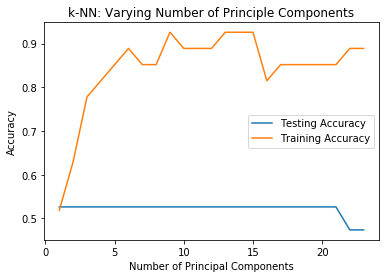

In [11]:
# Setup arrays to store train and test accuracies
n_components = np.arange(1, 24)
train_accuracy = np.empty(len(n_components))
test_accuracy = np.empty(len(n_components))

# Loop over different values of k
for i, k in enumerate(n_components):
    
    #setup a pipeline with a k-NN Classifier with k neighbors: knn
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=k)),
        ('classifier',GaussianNB())])

    #fit the pipeline to to the training data
    pipe.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = pipe.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = pipe.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Principle Components')
plt.plot(n_components, test_accuracy, label = 'Testing Accuracy')
plt.plot(n_components, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#setup arrays to store train and test accuracies
n_components = np.arange(1, 24)
train_accuracy = np.empty(len(n_components))
test_accuracy = np.empty(len(n_components))
train_accuracy_uns = np.empty(len(n_components))
test_accuracy_uns = np.empty(len(n_components))

#loop over different values of k
for i, k in enumerate(n_components):
    
    #setup a pipeline with scaler
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=k)),
        ('classifier', DecisionTreeClassifier())])

    #fit the pipeline to to the training data
    pipe.fit(X_train, y_train)
    
    #compute accuracy on the training set
    train_accuracy[i] = pipe.score(X_train, y_train)

    #compute accuracy on the testing set
    test_accuracy[i] = pipe.score(X_test, y_test)
    
    #setup a second pipeline with no scaler
    pipe_2 = Pipeline([
        ('reducer', PCA(n_components=k)),
        ('classifier', DecisionTreeClassifier())])

    #fit the pipeline to to the training data
    pipe_2.fit(X_train, y_train)
    
    #compute accuracy on the training set
    train_accuracy_uns[i] = pipe_2.score(X_train, y_train)

    #compute accuracy on the testing set
    train_accuracy_uns[i] = pipe_2.score(X_test, y_test)

#generate plot
plt.title('Decision Tree: Varying Number of Principal Components')
plt.plot(n_components, test_accuracy, label = 'Scaled Testing Accuracy')
plt.plot(n_components, train_accuracy, label = 'Scaled Training Accuracy')
plt.plot(n_components, test_accuracy_uns, label = 'Unscaled Testing Accuracy')
plt.plot(n_components, train_accuracy_uns, label = 'Unscaled Training Accuracy')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.show()

Seems to show overfitting. 